#Importing Necessary Libraries

In [ ]:
import re  # Import regular expressions for pattern matching
from keras.applications import efficientnet  # Import EfficientNet model from Keras applications
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for plotting graphs
import plotly.graph_objects as go  # Import Plotly for interactive graphs
import keras  # Import Keras for building neural networks
from keras.layers import TextVectorization  # Import TextVectorization layer from Keras
warnings.filterwarnings('ignore')  # Suppress warnings
from sklearn.model_selection import train_test_split  # Import train-test split function for dataset
import os  # Import OS for interacting with the operating system
from collections import Counter  # Import Counter to count hashable objects
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow debugging messages
import warnings  # Import warnings to control warning messages
from keras import layers  # Import layers module from Keras for neural network layers
from keras.preprocessing.image import load_img, img_to_array  # Import image loading and conversion utilities
import seaborn as sns  # Import Seaborn for statistical data visualization
from nltk.translate.bleu_score import corpus_bleu  # Import BLEU score metric for evaluating machine translation
from tqdm import tqdm_notebook  # Import tqdm for displaying progress bars in Jupyter notebooks
import tensorflow as tf  # Import TensorFlow for deep learning operations


#Loading Dataset and Setting some parameters

In [ ]:
# Path to the folder containing the images
path_for_the_image = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"
# Path to the CSV file containing the captions for the images
path_to_captions_ = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
# Target size for resizing the images
size_of_image_ = (299, 299)
# Maximum sequence length for the captions
sequence_length = 24
# Size of the vocabulary for the captions
vocabulary_size_ = 13000
# Dimension of the embedding layer for captions
embedded_dimension = 512
# Dimension of the feed-forward layers
FF_DIM = 512
# Batch size for training
batch_ = 32
# Number of epochs for training
epochs_ = 10


#Loading captioned from the dataset

In [ ]:
# Function to load captioned data from the CSV file
def function_for_loading_captioned_data_(filename):
    # Open the file containing captions
    with open(filename) as file_cap:
        # Read all lines except the header
        captioned_data = file_cap.readlines()[1:]
        cap_map_ = {}  # Dictionary to map image names to captions
        text_from_data_ = []  # List to store all captions
        img_to_ignore = set()  # Set of images to ignore due to short/long captions
        for line in captioned_data:
            line = line.rstrip("\n")
            try:
                # Split each line into image name and caption
                img_name, _, caption = line.split("| ")
            except ValueError:
                # Handle cases where the format is different (missing info)
                img_name, caption = line.split("| ")
                caption = caption[4:]  # Remove extra space in caption
            # Join image name with the directory path
            img_name = os.path.join(path_for_the_image, img_name.strip())
            # Tokenize the caption
            tokens = caption.strip().split()
            # Skip captions that are too short or too long
            if len(tokens) < 4 or len(tokens) > sequence_length:
                img_to_ignore.add(img_name)
                continue
            # Only process jpg images that are not in the ignore list
            if img_name.endswith("jpg") and img_name not in img_to_ignore:
                caption = "<start> " + caption.strip() + " <end>"  # Add start and end tokens
                text_from_data_.append(caption)  # Add caption to the list
                if img_name in cap_map_:
                    # Append caption to existing image entry
                    cap_map_[img_name].append(caption)
                else:
                    # Create a new entry for the image
                    cap_map_[img_name] = [caption]
        # Remove images that are in the ignore list
        for img_name in img_to_ignore:
            if img_name in cap_map_:
                del cap_map_[img_name]
        # Return the caption mapping and all captions
        return cap_map_, text_from_data_

# Function to split data into training, validation, and test sets
def function_for_train_test_split(captioned_data, valid_size=0.2, test_size=0.02):
    all_images = list(captioned_data.keys())  # Get all image names
    np.random.shuffle(all_images)  # Shuffle image names randomly
    # Split into training and validation sets
    train_keys, validation_keys = train_test_split(all_images, test_size=valid_size, random_state=42)
    # Further split the validation set into validation and test sets
    validation_keys, test_keys = train_test_split(validation_keys, test_size=test_size, random_state=42)
    # Create dictionaries for each dataset (train, validation, test)
    training_data = {img_name: captioned_data[img_name] for img_name in train_keys}
    validation_data = {img_name: captioned_data[img_name] for img_name in validation_keys}
    test_data = {img_name: captioned_data[img_name] for img_name in test_keys}
    # Return the split datasets
    return training_data, validation_data, test_data

# Load the captioned data and captions
captions_mapping, text_from_data_ = function_for_loading_captioned_data_(path_to_captions_)

# Split the data into training, validation, and test sets
train_data, validation_data, test_data = function_for_train_test_split(captions_mapping)
# Print the number of samples in the training and test sets
print(len(train_data))
print(len(test_data))


20915
105


#Cleaning the captions

In [ ]:
# Function to standardize the input string (lowercase and remove unwanted characters)
def standardization_(input_string):
    # Convert the input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # Define a list of characters to remove from the string
    strip_chars_ = "!\"#$%&'()[\]^_`{|}~1234567890*+,-./:;=?@"
    # Remove the unwanted characters using regex
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars_), "")

# Initialize the TextVectorization layer with specified parameters
vectorized_ = TextVectorization(max_tokens=vocabulary_size_,output_mode="int",output_sequence_length=sequence_length,standardize=standardization_)
# Adapt the TextVectorization layer to the text data
vectorized_.adapt(text_from_data_)

# Define a sequence of image augmentation layers
augmented_images_ = keras.Sequential([layers.RandomFlip("horizontal"),
                                       layers.RandomRotation(0.3),
                                       layers.RandomContrast(0.4)])

# Apply the standardization function to each caption in the text data and convert to list
text_from_data_ = list(map(lambda x: str(standardization_(x).numpy())[2:-1], text_from_data_))

#Calculating the frequency of words in captions

In [ ]:
# Function to count the frequency of words in the given data (captions)
def word_counter(data):
    # Join all the captions into a single string
    main_text = ' '.join(data)
    # Remove unnecessary words (like 'a', '<start>', and '<end>') from the text
    main_text = main_text.replace('a ', '')
    main_text = main_text.replace('<start> ', '')
    main_text = main_text.replace('<end> ', '')
    # Count the occurrences of each word in the text
    word_counts_ = Counter(main_text.split())
    # Extract the top 30 most frequent words
    words = list(word_counts_.keys())[:30]
    values = list(word_counts_.values())[:30]
    # Normalize the word frequencies to range between 0 and 1
    values_after_normalization_ = np.array(values) / np.max(values)
    # Generate color codes based on the normalized word frequencies (for visualization)
    colors = np.array(['rgba(30, 58, 138, {})'.format(0.4 + 0.5 * (value)) for value in values_after_normalization_])

# Call the function to process and count words in the text data
word_counter(text_from_data_)

#Preprocessing images for feeding the model

In [ ]:
# Function to read and preprocess images for the model
def res_dec_function_(img_path):
    # Read the image from the file path
    img = tf.io.read_file(img_path)
    # Decode the image to a tensor with 3 color channels (RGB)
    img_ = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to the desired size (299, 299)
    img = tf.image.resize(img_, size_of_image_)
    # Convert the image to float32 for compatibility with the model
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# Function to process the image and caption input for the model
def input_processing_function_(img_path, captions):
    # Return the processed image and caption (vectorized)
    return res_dec_function_(img_path), vectorized_(captions)

# Function to create a dataset from images and captions
def Building_dataset_(images, captions):
    # Create a dataset from the image paths and captions
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    # Shuffle the dataset
    dataset_ = dataset.shuffle(batch_ * 8)
    # Apply the image processing function to the dataset
    dataset_ = dataset_.map(input_processing_function_, num_parallel_calls=tf.data.AUTOTUNE)
    # Batch the dataset and prefetch it for improved performance
    dataset_ = dataset_.batch(batch_).prefetch(tf.data.AUTOTUNE)
    return dataset_

# Create the dataset for training and validation by passing image paths and captions
Dataset_for_training = Building_dataset_(list(train_data.keys()), list(train_data.values()))
Dataset_for_validation = Building_dataset_(list(validation_data.keys()), list(validation_data.values()))


In [ ]:
Dataset_for_validation

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None))>

#CNN architecture for extracting image features

In [ ]:
# Function to create a CNN model for feature extraction using EfficientNetB0
def CNN_model_for_feature_extraction_():
    # Load EfficientNetB0 model pre-trained on ImageNet without the top classification layers
    model_ = efficientnet.EfficientNetB0(input_shape=(*size_of_image_, 3), include_top=False, weights="imagenet")
    # Set the pre-trained layers as non-trainable (freeze the weights)
    model_.trainable = False
    # Get the output of the base EfficientNetB0 model
    base_model_out = model_.output
    # Reshape the output to a 2D tensor with the last dimension as the feature vector
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    # Create a new model using the input and reshaped output
    CNN_mod = keras.models.Model(model_.input, base_model_out)
    # Display the summary of the model architecture
    model_.summary()
    return CNN_mod

# Call the function to get the CNN model for feature extraction
x = CNN_model_for_feature_extraction_()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 299, 299, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 299, 299, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 299, 299, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

#Encoder

In [ ]:
# Define the Encoder class that inherits from the Keras Layer class
class Encoder_(layers.Layer):
    # Initialize the encoder with embedding dimension, dense dimension, and number of attention heads
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)  # Call the parent class constructor
        self.embed_dim = embed_dim  # Set the embedding dimension
        self.dense_dim = dense_dim  # Set the dense dimension
        self.num_heads = num_heads  # Set the number of attention heads
        # Define a multi-head attention layer
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.0)
        # Define two LayerNormalization layers
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        # Define a dense layer with ReLU activation
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    # Define the forward pass (call method) for the encoder
    def call(self, inputs, training, mask=None):
        # Apply the first layer normalization to the inputs
        inputs_ = self.layernorm_1(inputs)
        # Apply the dense layer to the normalized inputs
        inputs_ = self.dense_1(inputs_)
        # Apply multi-head attention on the inputs
        attention_output_1 = self.attention_1(query=inputs_, value=inputs_, key=inputs_, attention_mask=None, training=training)
        # Apply the second layer normalization and return the output
        OUTfromcall_ = self.layernorm_2(inputs_ + attention_output_1)
        return OUTfromcall_  # Return the processed output


#Positional Embedding

In [ ]:
# Define a custom Layer class POS_ENB for positional and token embeddings
class POS_ENB(layers.Layer):
    # Initialize the POS_ENB layer with sequence length, vocabulary size, and embedding dimension
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)  # Call the parent class constructor
        # Define the token embeddings layer
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Define the position embeddings layer
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        # Store the sequence length, vocabulary size, and embedding dimension
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        # Define a scaling factor for the embeddings
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    # Define the forward pass (call method) for token and position embeddings
    def call(self, inputs):
        # Get the sequence length from the input shape
        length = tf.shape(inputs)[-1]
        # Generate position indices from 0 to length - 1
        positions = tf.range(start=0, limit=length, delta=1)
        # Get the token embeddings for the input tokens
        emb_tok = self.token_embeddings(inputs)
        # Apply the embedding scale to the token embeddings
        emb_tok = emb_tok * self.embed_scale
        # Get the position embeddings for the position indices
        emb_pos = self.position_embeddings(positions)
        # Return the sum of the token and position embeddings
        return emb_tok + emb_pos

    # Define the method to compute the mask for padding tokens
    def compute_mask(self, inp_, mask=None):
        # Return a mask where 0s are treated as padding tokens (not equal to 0)
        return tf.math.not_equal(inp_, 0)


#Decoder

In [ ]:
# Define the TransformerDecoderBlock class, a custom layer for a Transformer decoder block
class TransformerDecoderBlock(layers.Layer):
    # Initialize the TransformerDecoderBlock with embedding dimension, feed-forward dimension, and number of attention heads
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)  # Call the parent class constructor
        self.embed_dim = embed_dim  # Store embedding dimension
        self.ff_dim = ff_dim  # Store feed-forward dimension
        self.num_heads = num_heads  # Store the number of attention heads
        # Define the self-attention layer
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        # Define the cross-attention layer
        self.cross_attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        # Define the feed-forward network layers
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)
        # Define the layer normalization layers
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        # Define the positional encoding and token embeddings
        self.embedding = POS_ENB(embed_dim=embedded_dimension, sequence_length=sequence_length, vocab_size=vocabulary_size_)
        # Define the output layer
        self.out = layers.Dense(vocabulary_size_, activation="softmax")
        # Define the dropout layers
        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        # Indicate that this layer supports masking
        self.supports_masking = True

    # Define the forward pass (call method) for the decoder block
    def call(self, inputs, encoder_outputs, training, mask=None):
        # Apply token and positional embeddings
        inputs = self.embedding(inputs)
        # Create the attention mask
        causal_mask = self.Atten_mask(inputs)
        # Combine the padding mask with the causal mask if a mask is provided
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)
        # Apply the self-attention layer
        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=combined_mask, training=training)
        # Apply layer normalization after self-attention
        out_1 = self.layernorm_1(inputs + attention_output_1)
        # Apply the cross-attention layer (attention with the encoder outputs)
        cross_attention_output_2 = self.cross_attention_2(query=out_1, value=encoder_outputs, key=encoder_outputs, attention_mask=padding_mask, training=training)
        # Apply layer normalization after cross-attention
        out_2 = self.layernorm_2(out_1 + cross_attention_output_2)
        # Apply the feed-forward network layers
        ffn_out = self.ffn_layer_1(out_2)
        # Apply dropout after the first feed-forward layer
        ffn_out = self.dropout_1(ffn_out, training=training)
        # Apply the second feed-forward layer
        ffn_out = self.ffn_layer_2(ffn_out)
        # Apply layer normalization after the feed-forward network
        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        # Apply dropout after the final layer
        ffn_out = self.dropout_2(ffn_out, training=training)
        # Generate predictions from the final output
        preds = self.out(ffn_out)
        return preds

    # Define the attention mask function for causal masking in the self-attention mechanism
    def Atten_mask(self, inputs):
        # Get the shape of the input
        input_shape_ = tf.shape(inputs)
        batch_size, sequence_length = input_shape_[0], input_shape_[1]
        # Create the attention mask using the sequence length
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        # Mask positions to ensure causal attention (no future tokens attended to)
        mask = tf.cast(i >= j, dtype="int32")
        # Reshape the mask to match the input dimensions
        mask = tf.reshape(mask, (1, input_shape_[1], input_shape_[1]))
        # Repeat the mask across the batch dimension
        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)  # Tile the mask to match batch size


#Main Calling Function (weights are being update in this section)

In [ ]:
# Define a custom model class 'caption_model' that inherits from Keras Model class
class caption_model(keras.Model):
    # Initialize the model with CNN model, encoder, decoder, and other parameters
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None):
        super().__init__()  # Call parent constructor
        self.cnn_model = cnn_model  # CNN model for feature extraction
        self.encoder = encoder  # Encoder model for processing image embeddings
        self.decoder = decoder  # Decoder model for generating captions
        self.loss_tracker = keras.metrics.Mean(name="loss")  # Loss tracker to track loss over training
        self.acc_tracker = keras.metrics.Mean(name="accuracy")  # Accuracy tracker
        self.num_captions_per_image = num_captions_per_image  # Number of captions to generate per image
        self.image_aug = image_aug  # Image augmentation function (optional)

    # Define the custom loss calculation
    def loss_cal(self, y_true, y_pred, mask):
        loss_ = self.loss(y_true, y_pred)  # Calculate loss between true labels and predictions
        mas_ = tf.cast(mask, dtype=loss_.dtype)  # Convert mask to the same dtype as the loss
        loss_ *= mas_  # Apply the mask to the loss
        return tf.reduce_sum(loss_) / tf.reduce_sum(mas_)  # Return the average loss over non-masked values

    # Define accuracy calculation method
    def loss_acc(self, y_true, y_pred, mask):
        accuracy_ = tf.equal(y_true, tf.argmax(y_pred, axis=2))  # Check if predicted values match true labels
        accuracy_ = tf.math.logical_and(mask, accuracy_)  # Ensure accuracy is computed only for non-masked positions
        accuracy_ = tf.cast(accuracy_, dtype=tf.float32)  # Convert to float32 for accurate summation
        mas_ = tf.cast(mask, dtype=tf.float32)  # Convert mask to float32
        return tf.reduce_sum(accuracy_) / tf.reduce_sum(mas_)  # Return accuracy over non-masked values

    # Method to compute loss and accuracy for each caption
    def acc_loss_comp(self, img_embed, batch_seq, training=True):
        enc_out = self.encoder(img_embed, training=training)  # Get encoder outputs from the image embeddings
        seq_inp = batch_seq[:, :-1]  # Take all tokens except the last one for input sequence
        seq_true = batch_seq[:, 1:]  # Take all tokens except the first one for true sequence
        mas_ = tf.math.not_equal(seq_true, 0)  # Create mask where true sequence is not equal to 0 (padding)
        batch_seq_pred_ = self.decoder(seq_inp, enc_out, training=training, mask=mas_)  # Generate predictions from the decoder
        loss = self.loss_cal(seq_true, batch_seq_pred_, mas_)  # Calculate loss using the true sequence and predictions
        acc = self.loss_acc(seq_true, batch_seq_pred_, mas_)  # Calculate accuracy using the true sequence and predictions
        return loss, acc  # Return the computed loss and accuracy

    # Custom train_step method for training the model
    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data  # Unpack the batch data into images and sequences
        batch_loss = 0  # Initialize batch loss
        batch_acc = 0  # Initialize batch accuracy
        if self.image_aug:  # If image augmentation is provided, apply it
            batch_img = self.image_aug(batch_img)
        img_embed = self.cnn_model(batch_img)  # Get image embeddings from the CNN model
        for i in range(self.num_captions_per_image):  # Loop through each caption per image
            with tf.GradientTape() as tape:  # Record gradients for backpropagation
                loss, acc = self.acc_loss_comp(img_embed, batch_seq[:, i, :], training=True)  # Compute loss and accuracy
                batch_loss += loss  # Accumulate loss for the batch
                batch_acc += acc  # Accumulate accuracy for the batch
            train_vars = (self.encoder.trainable_variables + self.decoder.trainable_variables)  # Get trainable variables
            grads = tape.gradient(loss, train_vars)  # Calculate gradients with respect to loss
            self.optimizer.apply_gradients(zip(grads, train_vars))  # Apply the gradients to update model weights
        batch_acc /= float(self.num_captions_per_image)  # Average the accuracy over all captions
        self.loss_tracker.update_state(batch_loss)  # Update loss tracker
        self.acc_tracker.update_state(batch_acc)  # Update accuracy tracker
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}  # Return loss and accuracy metrics

    # Custom test_step method for evaluating the model without updating weights
    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data  # Unpack the batch data into images and sequences
        batch_loss = 0  # Initialize batch loss
        batch_acc = 0  # Initialize batch accuracy

        img_embed = self.cnn_model(batch_img)  # Get image embeddings from the CNN model
        for i in range(self.num_captions_per_image):  # Loop through each caption per image
            loss, acc = self.acc_loss_comp(img_embed, batch_seq[:, i, :], training=False)  # Compute loss and accuracy
            batch_loss += loss  # Accumulate loss for the batch
            batch_acc += acc  # Accumulate accuracy for the batch

        batch_acc /= float(self.num_captions_per_image)  # Average the accuracy over all captions
        self.loss_tracker.update_state(batch_loss)  # Update loss tracker
        self.acc_tracker.update_state(batch_acc)  # Update accuracy tracker

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}  # Return loss and accuracy metrics


In [ ]:
@property
def metrics(self):
    return [self.loss_tracker, self.acc_tracker]

cnn_model = CNN_model_for_feature_extraction_()
encoder = Encoder_(embed_dim=embedded_dimension, dense_dim=FF_DIM, num_heads=2)
decoder = TransformerDecoderBlock(embed_dim=embedded_dimension, ff_dim=FF_DIM, num_heads=3)
caption_model = caption_model(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=augmented_images_)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 299, 299, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 299, 299, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 299, 299, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

#Compiling and training the model

In [ ]:
# Defining the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')


# Compiling the model
caption_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=cross_entropy)

# Training the model
history = caption_model.fit(Dataset_for_training, epochs = 20, validation_data=Dataset_for_validation)

Epoch 1/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 347s 470ms/step - acc: 0.2767 - loss: 23.6605 - val_acc: 0.3657 - val_loss: 17.5216
Epoch 2/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 307s 470ms/step - acc: 0.3583 - loss: 17.5945 - val_acc: 0.3843 - val_loss: 16.2889
Epoch 3/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 307s 469ms/step - acc: 0.3767 - loss: 16.4103 - val_acc: 0.3965 - val_loss: 15.7083
Epoch 4/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 307s 470ms/step - acc: 0.3894 - loss: 15.6929 - val_acc: 0.4029 - val_loss: 15.4209
Epoch 5/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 307s 470ms/step - acc: 0.3977 - loss: 15.1801 - val_acc: 0.4061 - val_loss: 15.2221
Epoch 6/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 307s 469ms/step - acc: 0.4062 - loss: 14.7702 - val_acc: 0.4071 - val_loss: 15.1050
Epoch 7/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 307s 470ms/step - acc: 0.4116 - loss: 14.4380 - val_acc: 0.4088 - val_loss: 15.0419
Epoch 8/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 315s 482ms/step - acc: 0.4175 - loss: 14.1253 - val_acc: 0.4114 - val_loss: 14.9840
Epoch 9/

#visualization for training and validation loss

In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#004EFF', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#00008B', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [ ]:
vocab = vectorized_.get_vocabulary()
INDEX_TO_WORD = {idx: word for idx, word in enumerate(vocab)}
MAX_DECODED_SENTENCE_LENGTH = sequence_length - 1
test_images = list(test_data.keys())

def greedy_algorithm(image):
    image = res_dec_function_(image)
    image = tf.expand_dims(image, 0)
    image = caption_model.cnn_model(image)
    encoded_img = caption_model.encoder(image, training=False)
    decoded_caption = "<start> "
    for i in range(MAX_DECODED_SENTENCE_LENGTH):
        tokenized_caption = vectorized_([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(tokenized_caption, encoded_img, training=False, mask=mask)
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = INDEX_TO_WORD[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()

    return decoded_caption

#Calculating the Bleu Scores for the first 50 testing images

Calculating BLEU Scores:   0%|          | 0/50 [00:00<?, ?it/s]

Image ID: /kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/263984805.jpg
  BLEU-4: 0.12526
  BLEU-3: 0.08267
  BLEU-2: 0.12649
  BLEU-1: 0.28
  Generated Caption: a man in a white shirt is using a hammer and chisel to do woodworking
--------------------------------------------------
Image ID: /kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/3475621874.jpg
  BLEU-4: 0.15939
  BLEU-3: 0.11218
  BLEU-2: 0.17406
  BLEU-1: 0.2954
  Generated Caption: a man in a blue shirt is eating a sandwich
--------------------------------------------------
Image ID: /kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/4935946626.jpg
  BLEU-4: 0.07401
  BLEU-3: 0.11658
  BLEU-2: 0.13898
  BLEU-1: 0.23581
  Generated Caption: a woman in a red shirt walks past a brick wall
--------------------------------------------------
Image ID: /kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/4281866877.jpg
  BLEU-4: 0.15771
  BLEU-3: 0.12431
 

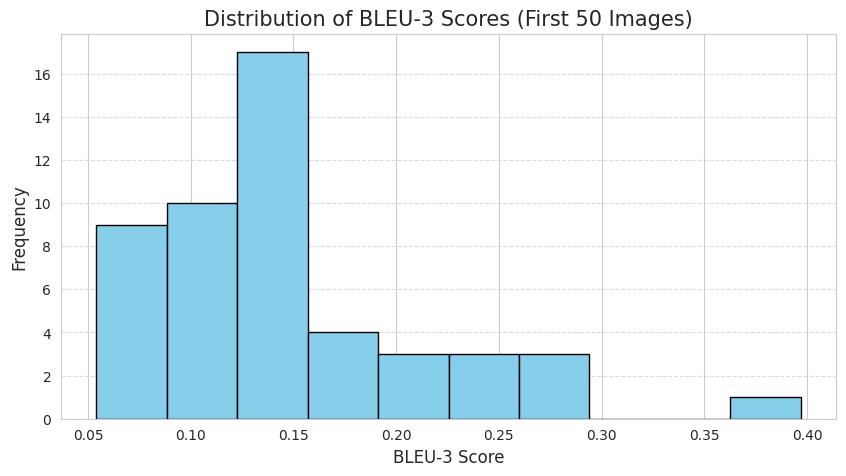

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Function to calculate BLEU scores
def BLEU_score(actual, predicted):
    processed_actual = []
    for i in actual:
        cap = [INDEX_TO_WORD[x] for x in vectorized_(i).numpy() if INDEX_TO_WORD[x] != '']
        cap = ' '.join(cap)
        processed_actual.append(cap)

    # Fixing the references and hypotheses length mismatch
    references = [[cap.split()] for cap in processed_actual]
    hypothesis = predicted.split()

    b1 = corpus_bleu(references, [hypothesis] * len(references), weights=(1.0, 0, 0, 0))
    b2 = corpus_bleu(references, [hypothesis] * len(references), weights=(0.5, 0.5, 0, 0))
    b3 = corpus_bleu(references, [hypothesis] * len(references), weights=(0.3, 0.3, 0.3, 0))
    b4 = corpus_bleu(references, [hypothesis] * len(references), weights=(0.25, 0.25, 0.25, 0.25))

    return {
        "BLEU-4": round(b4, 5),
        "BLEU-3": round(b3, 5),
        "BLEU-2": round(b2, 5),
        "BLEU-1": round(b1, 5),
    }


# Generate captions for the first 50 images in the test dataset
generated_captions = {}
bleu_scores = {}
test_data_subset = dict(list(test_data.items())[:50])  # First 50 images

pbar = tqdm(total=len(test_data_subset), desc="Calculating BLEU Scores", position=0, leave=True, colour='green')

for image_id in test_data_subset:
    # Generate a caption for the image
    generated_caption = greedy_algorithm(image_id)
    generated_captions[image_id] = generated_caption

    # Get the actual captions for the image
    actual_captions = test_data_subset[image_id]

    # Calculate BLEU scores
    bleu_scores[image_id] = BLEU_score(actual_captions, generated_caption)

    pbar.update(1)

pbar.close()

# Display the BLEU scores for the first 50 images
for image_id, scores in bleu_scores.items():
    print(f"Image ID: {image_id}")
    for metric, score in scores.items():
        print(f"  {metric}: {score}")
    print(f"  Generated Caption: {generated_captions[image_id]}")
    print("-" * 50)

# Visualizing BLEU scores distribution for the first 50 images
bleu4_scores = [score["BLEU-3"] for score in bleu_scores.values()]

plt.figure(figsize=(10, 5))
plt.hist(bleu4_scores, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of BLEU-3 Scores (First 50 Images)", fontsize=15)
plt.xlabel("BLEU-3 Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#Generating caption on a image taken from web

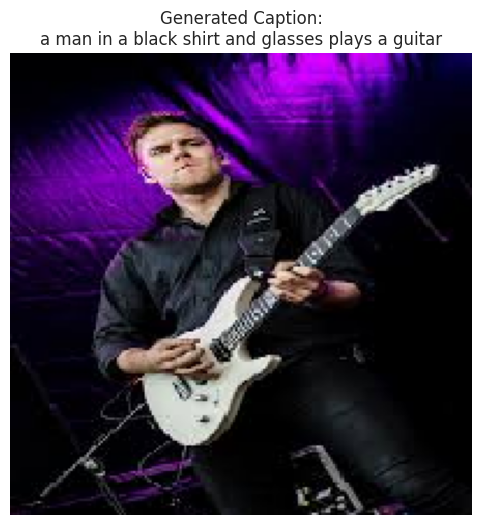

In [ ]:
def generate_caption_and_visualize(image_path):
    # Generate caption for the given image
    generated_caption = greedy_algorithm(image_path)

    # Load and display the image
    image_load = load_img(image_path, target_size=(199, 199, 3))

    # Visualize the image and its generated caption
    plt.figure(figsize=(6, 6))
    plt.imshow(image_load)
    plt.axis('off')
    plt.title(f"Generated Caption:\n{generated_caption}")
    plt.show()
    return generated_caption

image_path = "/kaggle/input/test-pic/download (2).jpeg"
n = generate_caption_and_visualize(image_path)


#Text Generator for the captions Generated

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

def generate_three_word_title(text, model_name='t5-small', max_length=8):
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    # Modify the input prompt for better alignment with T5's training
    input_text = f"summarize in three words only : {text}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Generate the title
    outputs = model.generate(
        input_ids=input_ids,
        max_length=max_length,
        num_beams=5,
        early_stopping=True
    )

    # Decode the output
    title = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return title

# Test with an example sentence
input_text = n
three_word_title = generate_three_word_title(input_text, model_name='t5-small')
print(f"Generated Title: {three_word_title}")


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generated Title: a man in a black
